In [1]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE

In [3]:
df = pd.read_csv("SET_processed_latest_version.csv")

In [4]:
for i in range(df.shape[1]):
    df.iloc[:,i]= df.iloc[:,i].replace([555, 777,888,999,'555','777','888','999' ], np.nan)

In [5]:
text=df.loc[:,['S6b_Other_Activities','S11a_Comments','A1_Description','A2_Description','A3_Description','O1_other_group_name','Group_name_part1','PUSH_1','PULL_1']]

In [6]:
text["text_all"] = text.apply(lambda x: ','.join(x.dropna()), axis=1)
text.head()

,S6b_Other_Activities,S11a_Comments,A1_Description,A2_Description,A3_Description,O1_other_group_name,Group_name_part1,PUSH_1,PULL_1,text_all
0,"Working out, CBT, boxing","School. Poor grades, car accident, not enough ...",School,NaN,School,Other group,Group,Somebody got out of jail that brought a lot of...,School. work. moving,"Working out, CBT, boxing,School. Poor grades, ..."
1,Basketball,Mother died,Basketball,NaN,NaN,No name,Money Gang,NaN,NaN,"Basketball,Mother died,Basketball,No name,Mone..."
2,Extra activities with children,Favor cousin was murder and never found his ki...,"Church, job and school",Church choir and praise team,NaN,Church group,No group,NaN,NaN,"Extra activities with children,Favor cousin wa..."
3,Actor/dance,Best friend brother was murder [sic] by 16 and...,"Church, school and job",Church choir and praise team,NaN,No name,No name,NaN,NaN,"Actor/dance,Best friend brother was murder [si..."
4,Singing,Best fried brother was murder [sic] by 18yr boy,"Church, job, and school",Church choir and praise team,NaN,No name,No name,NaN,NaN,"Singing,Best fried brother was murder [sic] by..."


In [7]:
# Drop NA values and convert to a list
contents = text['S6b_Other_Activities'].dropna().values.tolist()
len(contents)
# len(activities) # 1466 valid answers

1466

In [8]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(contents)
X.shape

(1466, 696)

In [9]:
pca = PCA(n_components=2, random_state=25)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(1466, 2)

In [10]:
distortions = []
K = range(3, 15)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=25).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

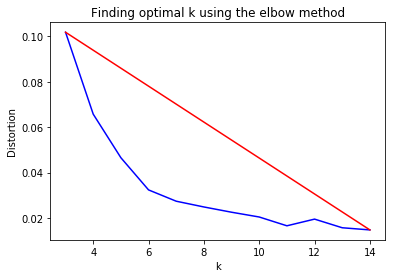

In [11]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# plot elbow method
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Finding optimal k using the elbow method')
plt.show()

In [20]:
k = 6# number of clusters (may need to change)
model = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=1)
model.fit(X)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=6, n_init=1, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [21]:
print("Top terms in each cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :6]:
        print(' %s' % terms[ind]),
    print

print("\n")

Top terms in each cluster:
Cluster 0:
 hygiene
 work
 job
 readiness
 program
 volunteer
Cluster 1:
 church
 volunteer
 football
 activities
 attend
 volunteering
Cluster 2:
 gryd
 program
 workshops
 sea
 just
 attends
Cluster 3:
 community
 school
 life
 search
 skills
 counseling
Cluster 4:
 basketball
 play
 playing
 client
 plays
 park
Cluster 5:
 gym
 client
 goes
 basketball
 work
 membership




In [22]:
tsne = TSNE(verbose=1, perplexity=100, random_state=25)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 1466 samples in 0.057s...
[t-SNE] Computed neighbors for 1466 samples in 5.937s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1466
[t-SNE] Computed conditional probabilities for sample 1466 / 1466
[t-SNE] Mean sigma: 0.580070
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.612770
[t-SNE] KL divergence after 1000 iterations: 1.130853


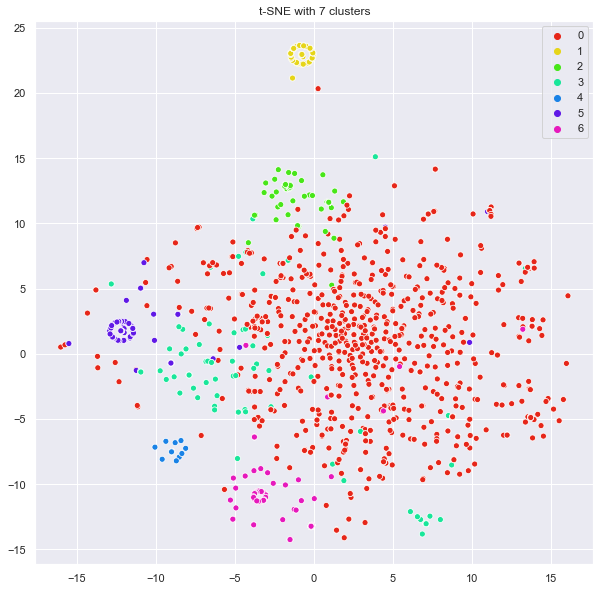

In [15]:

import matplotlib.pyplot as plt
import seaborn as sns
X_embedded_all = X_embedded
y_pred = model.fit_predict(X)
sns.set(rc={'figure.figsize':(10,10)})
palette = sns.hls_palette(k, l=.5, s=.8)

sns.scatterplot(X_embedded_all[:,0], X_embedded_all[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with {} clusters'.format(k))
plt.show()

In [16]:
np.count_nonzero(y_pred==2)

84

In [17]:
model.predict(X).shape

(1466,)

In [18]:
# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(model.cluster_centers_)

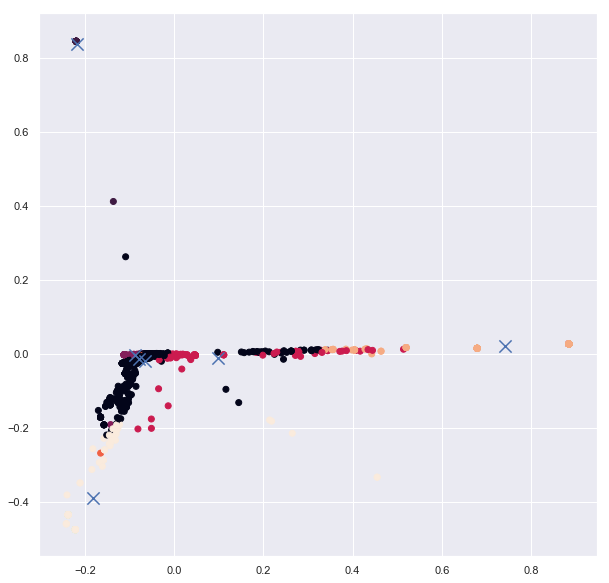

In [19]:
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=model.predict(X))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')